In [1]:
import os
import sys
import re

project_root = "/root/work/tenset"
os.environ["TVM_HOME"] = f"{project_root}"
os.environ["TVM_LIBRARY_PATH"] = f"{project_root}/build"
if f"{project_root}/python" not in sys.path:
    sys.path.insert(0, f"{project_root}/python")

sys.path = [p for p in sys.path if not p.startswith(f"{project_root}/build")]
sys.path.append(f"{project_root}/build")
os.environ["LD_LIBRARY_PATH"] = f"{project_root}/build:" + os.environ.get("LD_LIBRARY_PATH", "")

In [22]:
import sys
sys.path.append("/root/work/tenset/scripts")

from tvm import auto_scheduler
from print_programs import return_program
from tvm.auto_scheduler.feature import get_per_store_features_from_file, get_per_store_features_from_measure_pairs
from make_dataset import load_and_register_tasks
import numpy as np
from glob import glob
import random
# random.seed(42)

# json_file = glob("/root/work/tenset/dataset/measure_records_tenset/k80/*.json")[random.randint(0, 1)]
json_file = "/root/work/tenset/dataset/measure_records_tenset/k80/([0bcb8746286db050cd088f375c85372d,1,64,64,128,6,6,32,128,1,64,64,32],cuda).json"
load_and_register_tasks()
print("")
# inputs, results = auto_scheduler.RecordReader(json_file).read_lines()
# raw_features, raw_normalized_throughputs, task_ids, min_latency = get_per_store_features_from_file(json_file, 10000)

In [23]:

inputs, results = auto_scheduler.RecordReader(json_file).read_lines()
# m_features = get_per_store_features_from_measure_pairs(inputs, results)


raw_features, raw_normalized_throughputs, task_ids, min_latency = get_per_store_features_from_file(json_file, 10000)


In [24]:
features = []
costs = []
segment_sizes = []
for feature, throughput, r in zip(raw_features, raw_normalized_throughputs, results):
    if throughput > 1.0e-10:
        features.append(feature)
        cost = -np.log(np.mean([c.value for c in r.costs]), dtype=np.float32)
        # cost = -np.log(throughput)
        if cost < 0:
            cost = 0.0
        costs.append(cost)
        segment_sizes.append(feature.shape[0])


# features = np.array(features, dtype=np.float32)[:128]
# costs = np.array(costs, dtype=np.float32)[:128]
# segment_sizes = np.array(segment_sizes, dtype=np.int32)[:128]

features = np.array(features, dtype=np.float32)
costs = np.array(costs, dtype=np.float32)
segment_sizes = np.array(segment_sizes, dtype=np.int32)

flatten_features = np.concatenate(features, axis=0).astype(np.float32)
print(f"총 샘플 수: {len(costs)}")
print(f"Flatten된 features shape: {flatten_features.shape}")
print(f"Segment sizes - Min: {segment_sizes.min()}, Max: {segment_sizes.max()}, Mean: {segment_sizes.mean():.2f}")

총 샘플 수: 3464
Flatten된 features shape: (27712, 164)
Segment sizes - Min: 8, Max: 8, Mean: 8.00


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader
import random

# 시드 고정
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

class SegmentRegressionDataset:
    """SegmentDataLoader 패턴을 따르는 데이터셋"""
    def __init__(self, segment_sizes, features, labels, batch_size, device, 
                 fea_norm_vec=None, shuffle=False, seed=42):
        self.device = device
        self.shuffle = shuffle
        self.seed = seed
        self.number = len(labels)
        self.batch_size = batch_size
        
        self.segment_sizes = torch.tensor(segment_sizes, dtype=torch.int32)
        self.labels = torch.tensor(labels, dtype=torch.float32)
        self.features = torch.tensor(features, dtype=torch.float32)
        
        if fea_norm_vec is not None:
            self.normalize(fea_norm_vec)
        
        self.feature_offsets = (
            torch.cumsum(self.segment_sizes, 0, dtype=torch.int32) - self.segment_sizes
        ).cpu().numpy()
        
        self.iter_order = self.pointer = None
        self.rng = np.random.RandomState(seed)
    
    def normalize(self, norm_vector=None):
        if norm_vector is None:
            norm_vector = torch.ones((self.features.shape[1],))
            for i in range(self.features.shape[1]):
                max_val = self.features[:, i].max().item()
                if max_val > 0:
                    norm_vector[i] = max_val
        self.features /= norm_vector
        return norm_vector
    
    def __iter__(self):
        if self.shuffle:
            self.iter_order = torch.from_numpy(self.rng.permutation(self.number))
        else:
            self.iter_order = torch.arange(self.number)
        self.pointer = 0
        return self
    
    def __next__(self):
        if self.pointer >= self.number:
            raise StopIteration
        
        batch_indices = self.iter_order[self.pointer: self.pointer + self.batch_size]
        self.pointer += self.batch_size
        return self._fetch_indices(batch_indices)
    
    def _fetch_indices(self, indices):
        segment_sizes = self.segment_sizes[indices]
        
        feature_offsets = self.feature_offsets[indices]
        feature_indices = np.empty((segment_sizes.sum().item(),), dtype=np.int32)
        ct = 0
        for offset, seg_size in zip(feature_offsets, segment_sizes.numpy()):
            feature_indices[ct: ct + seg_size] = np.arange(offset, offset + seg_size, 1)
            ct += seg_size
        
        features = self.features[feature_indices]
        labels = self.labels[indices]
        return (x.to(self.device) for x in (segment_sizes, features, labels))
    
    def __len__(self):
        return self.number


# Train/Val 분할
n_samples = len(costs)
indices = np.arange(n_samples)
train_indices, val_indices = train_test_split(indices, test_size=0.2, shuffle=False)

train_segment_sizes = segment_sizes[train_indices]
val_segment_sizes = segment_sizes[val_indices]
train_labels = costs[train_indices]
val_labels = costs[val_indices]

train_feature_list = [features[i] for i in train_indices]
val_feature_list = [features[i] for i in val_indices]

train_flatten_features = np.concatenate(train_feature_list, axis=0).astype(np.float32)
val_flatten_features = np.concatenate(val_feature_list, axis=0).astype(np.float32)

print(f"훈련 샘플 수: {len(train_labels)}, 검증 샘플 수: {len(val_labels)}")
print(f"훈련 flatten features: {train_flatten_features.shape}")
print(f"검증 flatten features: {val_flatten_features.shape}")

# 정규화
fea_norm_vec = torch.ones((train_flatten_features.shape[1],))
for i in range(train_flatten_features.shape[1]):
    max_val = float(train_flatten_features[:, i].max())
    if max_val > 0:
        fea_norm_vec[i] = max_val

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ⚡ 배치 크기 증가: 128 → 256 (GPU 활용률 향상)
train_loader = SegmentRegressionDataset(
    train_segment_sizes, train_flatten_features, train_labels,
    batch_size=256, device=device, fea_norm_vec=fea_norm_vec, shuffle=False, seed=SEED
)
val_loader = SegmentRegressionDataset(
    val_segment_sizes, val_flatten_features, val_labels,
    batch_size=256, device=device, fea_norm_vec=fea_norm_vec, shuffle=False, seed=SEED
)

X_train = train_flatten_features
X_val = val_flatten_features
y_train = train_labels
y_val = val_labels
train_dataset = train_loader
val_dataset = val_loader

print(f"✅ 데이터셋 준비 완료 (배치 크기: 256)")


훈련 샘플 수: 2771, 검증 샘플 수: 693
훈련 flatten features: (22168, 164)
검증 flatten features: (5544, 164)
✅ 데이터셋 준비 완료 (배치 크기: 256)


In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import r2_score
import random

# 시드 고정
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

class SegmentVAE(nn.Module):
    """
    Segment-level VAE:
    1. Segment Encoder: 각 row를 hidden_dim으로 변환
    2. Segment Sum: row들을 segment별로 합산
    3. VAE: 합산된 벡터를 encode → decode (reconstruction)
    """
    def __init__(self, input_dim, hidden_dim=256, latent_dim=64, dropout=0.1):
        super(SegmentVAE, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.use_mean = False
        
        # ========== Segment Encoder (VAE 전에 적용) ==========
        self.segment_encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        
        # ========== VAE Encoder (segment sum 후 적용) ==========
        self.norm = nn.BatchNorm1d(hidden_dim)
        
        # Residual 레이어들
        self.l0 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.l1 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        
        # VAE latent parameters
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # ========== VAE Decoder (hidden_dim으로 reconstruction) ==========
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),  # 출력: segment sum 벡터 (hidden_dim)
        )
        
    def segment_sum(self, segment_sizes, features):
        """SegmentSum: 각 segment 내 row들을 합산"""
        n_seg = segment_sizes.shape[0]
        device = features.device
        segment_sizes = segment_sizes.long()
        
        segment_indices = torch.repeat_interleave(
            torch.arange(n_seg, device=device), segment_sizes
        )
        
        n_dim = features.shape[1]
        segment_sum = torch.scatter_add(
            torch.zeros((n_seg, n_dim), dtype=features.dtype, device=device),
            0,
            segment_indices.view(-1, 1).expand(-1, n_dim),
            features,
        )
        return segment_sum
    
    def encode(self, h):
        """VAE Encoder: segment sum 벡터 → (mean, logvar)"""
        # BatchNorm
        h = self.norm(h)
        
        # Residual connections
        h = self.l0(h) + h
        h = self.l1(h) + h
        
        # Latent parameters
        mean = self.fc_mean(h)
        logvar = self.fc_logvar(h)
        if self.use_mean:
            logvar = torch.zeros_like(mean)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        """Reparameterization trick"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def decode(self, z):
        """VAE Decoder: latent z → reconstructed segment sum 벡터"""
        return self.decoder(z)
    
    def forward(self, segment_sizes, features, use_mean=False):
        """
        Forward pass:
        1. Segment Encoder: features → hidden
        2. Segment Sum: hidden → segment-level 벡터
        3. VAE: encode → reparameterize → decode
        """
        # 1. Segment Encoder
        h = self.segment_encoder(features)  # (total_rows, hidden_dim)
        
        # 2. Segment Sum
        segment_sum_vec = self.segment_sum(segment_sizes, h)  # (n_seg, hidden_dim)
        
        self.use_mean = use_mean

        # 3. VAE Encode
        mean, logvar = self.encode(segment_sum_vec)
        
        # 4. Reparameterize
        z = self.reparameterize(mean, logvar)
        
        # 5. VAE Decode (reconstruct segment sum 벡터)
        recon = self.decode(z)  # (n_seg, hidden_dim)
        
        return mean, logvar, z, recon, segment_sum_vec


def vae_loss(recon, original, mean, logvar, beta):
    """
    VAE Loss = Reconstruction Loss + β * KL Divergence
    - Reconstruction: MSE between original and reconstructed segment sum 벡터
    - KLD: D_KL(q(z|x) || p(z)), where p(z) = N(0, I)
    """
    recon_loss = F.mse_loss(recon, original, reduction='sum')
    kld_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    
    total_loss = recon_loss + beta * kld_loss
    return total_loss, recon_loss, kld_loss


print("Segment VAE 모델 정의 완료!")
print(f"- Input dim: {train_flatten_features.shape[1]}")
print(f"- Hidden dim: 256")
print(f"- Latent dim: 64")
print("Flow: features → segment_encoder → segment_sum → VAE (encode/decode)")

Segment VAE 모델 정의 완료!
- Input dim: 164
- Hidden dim: 256
- Latent dim: 64
Flow: features → segment_encoder → segment_sum → VAE (encode/decode)


In [27]:
# ⚡ VAE 학습 최적화 버전 (Mixed Precision + 빠른 학습)
from itertools import product

def train_vae_single_config(train_loader, val_loader, input_dim, device,
                            hidden_dim, latent_dim, beta, lr, dropout=0.1,
                            num_epochs=100, patience=20, verbose=False):
    """단일 설정으로 VAE 학습 (최적화 버전)"""
    
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)
    
    model = SegmentVAE(input_dim, hidden_dim, latent_dim, dropout).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20, T_mult=2)
    
    # ⚡ Mixed Precision Training 설정
    scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
    use_amp = scaler is not None
    
    best_recon_r2 = -float('inf')
    patience_counter = 0
    best_state = None
    history = {'recon_r2': [], 'kl_per_dim': [], 'recon_loss': []}
    
    for epoch in range(num_epochs):
        model.train()
        epoch_kl = 0.0
        epoch_recon = 0.0
        n_batches = 0
        
        for segment_sizes_batch, features_batch, _ in train_loader:
            optimizer.zero_grad(set_to_none=True)  # ⚡ 더 빠른 zero_grad
            
            # ⚡ Mixed Precision Forward
            if use_amp:
                with torch.cuda.amp.autocast():
                    mean, logvar, z, recon, segment_sum_vec = model(segment_sizes_batch, features_batch)
                    loss, recon_loss, kld_loss = vae_loss(recon, segment_sum_vec, mean, logvar, beta)
                
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                mean, logvar, z, recon, segment_sum_vec = model(segment_sizes_batch, features_batch)
                loss, recon_loss, kld_loss = vae_loss(recon, segment_sum_vec, mean, logvar, beta)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
            
            # KL per dimension 계산 (평균)
            batch_kl_per_dim = kld_loss.item() / (mean.shape[0] * latent_dim)
            epoch_kl += batch_kl_per_dim
            epoch_recon += recon_loss.item() / mean.shape[0]
            n_batches += 1
        
        scheduler.step()
        avg_kl_per_dim = epoch_kl / n_batches
        avg_recon = epoch_recon / n_batches
        
        # Validation (매 5 에폭마다만 체크하여 속도 향상)
        if (epoch + 1) % 5 == 0 or epoch == num_epochs - 1:
            model.eval()
            val_recons, val_originals = [], []
            val_kl_per_dim = 0.0
            val_batches = 0
            
            with torch.no_grad():
                for segment_sizes_batch, features_batch, _ in val_loader:
                    if use_amp:
                        with torch.cuda.amp.autocast():
                            mean, logvar, z, recon, segment_sum_vec = model(segment_sizes_batch, features_batch, use_mean=True)
                            kld = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
                    else:
                        mean, logvar, z, recon, segment_sum_vec = model(segment_sizes_batch, features_batch, use_mean=True)
                        kld = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
                    
                    val_kl_per_dim += kld.item() / (mean.shape[0] * latent_dim)
                    val_batches += 1
                    val_recons.append(recon.cpu().numpy())
                    val_originals.append(segment_sum_vec.cpu().numpy())
            
            val_kl_per_dim /= val_batches
            recon_r2 = r2_score(
                np.concatenate(val_originals).flatten(),
                np.concatenate(val_recons).flatten()
            )
            
            history['recon_r2'].append(recon_r2)
            history['kl_per_dim'].append(val_kl_per_dim)
            history['recon_loss'].append(avg_recon)
            
            if recon_r2 > best_recon_r2:
                best_recon_r2 = recon_r2
                patience_counter = 0
                best_state = model.state_dict().copy()
                best_kl_per_dim = val_kl_per_dim
            else:
                patience_counter += 1
            
            if verbose and (epoch + 1) % 50 == 0:
                print(f"  Epoch {epoch+1}: R²={recon_r2:.4f}, KL/dim={val_kl_per_dim:.4f}")
            
            if patience_counter >= patience:
                break
    
    model.load_state_dict(best_state)
    return model, best_recon_r2, best_kl_per_dim, history


def hyperparameter_search(train_loader, val_loader, input_dim, device,
                          target_kl_range=(0.05, 0.2), target_r2=0.95,
                          num_epochs=300, patience=40):
    """
    하이퍼파라미터 탐색:
    - KL/latent_dim이 0.05~0.2 범위에 있도록 우선 조정
    """
    
    # 하이퍼파라미터 그리드

    # configs = {
    #     "hidden_dim": [256, 512],
    #     "latent_dim": [64, 128],
    #     "beta": [1e-5, 5e-5, 1e-4, 2e-4, 5e-4, 1e-3],
    #     "lr": [1e-3, 5e-4, 2e-4],
    # }

    
    
    
    all_results = []
    best_score = -float('inf')
    best_config = None
    best_model = None
    
    config_idx = 0
    configs = [
        {'hidden_dim': 256, 'latent_dim': 64,  'beta': 1e-04, 'lr': 1e-03},
        {'hidden_dim': 256, 'latent_dim': 64,  'beta': 1e-04, 'lr': 2e-04},
        {'hidden_dim': 256, 'latent_dim': 64,  'beta': 2e-04, 'lr': 1e-03},

        {'hidden_dim': 256, 'latent_dim': 128, 'beta': 5e-05, 'lr': 1e-03},
        {'hidden_dim': 256, 'latent_dim': 128, 'beta': 5e-05, 'lr': 5e-04},
        {'hidden_dim': 256, 'latent_dim': 128, 'beta': 5e-05, 'lr': 2e-04},
        {'hidden_dim': 256, 'latent_dim': 128, 'beta': 1e-04, 'lr': 5e-04},
        {'hidden_dim': 256, 'latent_dim': 128, 'beta': 1e-04, 'lr': 2e-04},
        {'hidden_dim': 256, 'latent_dim': 128, 'beta': 1e-04, 'lr': 1e-03},
        {'hidden_dim': 256, 'latent_dim': 128, 'beta': 1e-03, 'lr': 2e-04},
    ]

    if isinstance(configs, dict):
        keys = list(configs.keys())
        values_product = list(product(*[configs[k] for k in keys]))
        config_list = [dict(zip(keys, vals)) for vals in values_product]
    elif isinstance(configs, list):
        config_list = configs
    else:
        raise ValueError("configs는 dict (각 값이 리스트) 이거나 dict의 리스트여야 합니다.")

    total_configs = len(config_list)

    print("=" * 70)
    print("⚡ VAE 하이퍼파라미터 탐색 (최적화 버전)")
    print("=" * 70)
    print(f"목표 KL/dim 범위: {target_kl_range}")
    print(f"목표 R²: >= {target_r2}")
    print(f"Configurations to try ({total_configs}개)")
    print(f"⚡ 최적화: Mixed Precision + 배치크기 256 + 에폭 {num_epochs} + Patience {patience}")
    print()

    for config in config_list:
        hidden_dim = config['hidden_dim']
        latent_dim = config['latent_dim']
        beta = config['beta']
        lr = config['lr']
        config_idx += 1
        print(f"\n[{config_idx}/{total_configs}] hidden={hidden_dim}, latent={latent_dim}, β={beta:.0e}, lr={lr:.0e}")
        
        try:
            model, recon_r2, kl_per_dim, history = train_vae_single_config(
                train_loader, val_loader, input_dim, device,
                hidden_dim=hidden_dim,
                latent_dim=latent_dim,
                beta=beta,
                lr=lr,
                num_epochs=num_epochs,
                patience=patience,
                verbose=False
            )
            
            # KL/dim 범위 체크
            kl_min, kl_max = target_kl_range
            in_kl_range = kl_min <= kl_per_dim <= kl_max
            
            # 스코어 계산: R² 기준, KL 범위 벗어나면 페널티
            if in_kl_range:
                score = recon_r2
                kl_status = "✓"
            else:
                # 범위를 벗어난 정도에 따라 페널티
                if kl_per_dim < kl_min:
                    penalty = (kl_min - kl_per_dim) / kl_min
                else:
                    penalty = (kl_per_dim - kl_max) / kl_max
                score = recon_r2 - penalty * 0.3  # 최대 10% 페널티
                kl_status = "✗"
            
            result = {
                **config,
                'recon_r2': recon_r2,
                'kl_per_dim': kl_per_dim,
                'in_kl_range': in_kl_range,
                'score': score,
                'model': model,
                'history': history
            }
            all_results.append(result)
            
            print(f"  → R²={recon_r2:.4f}, KL/dim={kl_per_dim:.4f} {kl_status}, Score={score:.4f}")
            
            if score > best_score:
                best_score = score
                best_config = config
                best_model = model
                best_result = result
                print(f"  ★ 새로운 최고!")
            
        except Exception as e:
            print(f"  오류: {e}")
            continue
    
    # 결과 정렬 및 출력
    print("\n" + "=" * 70)
    print("탐색 결과 (Score 기준 상위 10개)")
    print("=" * 70)
    
    sorted_results = sorted(all_results, key=lambda x: x['score'], reverse=True)
    
    print(f"{'Rank':<5} {'Hidden':<8} {'Latent':<8} {'β':<10} {'LR':<10} {'R²':<8} {'KL/dim':<10} {'KL범위':<8} {'Score':<8}")
    print("-" * 85)
    
    for i, res in enumerate(sorted_results[:10]):
        kl_status = "✓" if res['in_kl_range'] else "✗"
        print(f"{i+1:<5} {res['hidden_dim']:<8} {res['latent_dim']:<8} {res['beta']:<10.0e} {res['lr']:<10.0e} {res['recon_r2']:<8.4f} {res['kl_per_dim']:<10.4f} {kl_status:<8} {res['score']:<8.4f}")
    
    print("\n" + "=" * 70)
    print("최적 설정")
    print("=" * 70)
    print(f"Hidden dim: {best_config['hidden_dim']}")
    print(f"Latent dim: {best_config['latent_dim']}")
    print(f"β: {best_config['beta']}")
    print(f"Learning rate: {best_config['lr']}")
    print(f"Reconstruction R²: {best_result['recon_r2']:.4f}")
    print(f"KL/dim: {best_result['kl_per_dim']:.4f}")
    print(f"KL 범위 내: {'예' if best_result['in_kl_range'] else '아니오'}")
    
    return best_model, best_config, sorted_results


print("⚡ 하이퍼파라미터 탐색 함수 정의 완료 (최적화 버전)!")
print("   - Mixed Precision Training 활성화")
print("   - 배치 크기: 256")
print("   - 에폭: 150 (기존 300)")
print("   - Patience: 20 (기존 40)")
print("   - Validation 간격: 5 에폭마다")


⚡ 하이퍼파라미터 탐색 함수 정의 완료 (최적화 버전)!
   - Mixed Precision Training 활성화
   - 배치 크기: 256
   - 에폭: 150 (기존 300)
   - Patience: 20 (기존 40)
   - Validation 간격: 5 에폭마다


In [28]:
# ⚡ VAE 하이퍼파라미터 탐색 실행 (최적화 버전)
print("=" * 60)
print("⚡ VAE 하이퍼파라미터 탐색 시작 (최적화 버전)")
print("=" * 60)

input_dim = train_flatten_features.shape[1]

# ⚡ 에폭/patience 감소로 학습 속도 향상
pretrained_vae, best_config, all_results = hyperparameter_search(
    train_loader, val_loader, input_dim, device,
    target_kl_range=(0.1, 0.3),
    target_r2=0.95,
    num_epochs=100,  # 200 → 100 (Mixed Precision으로 더 빠른 수렴)
    patience=15      # 30 → 15
)

# 최적 β 저장 (시각화용)
best_beta = best_config['beta']

print("\n" + "=" * 60)
print("VAE 하이퍼파라미터 탐색 완료!")
print("=" * 60)


⚡ VAE 하이퍼파라미터 탐색 시작 (최적화 버전)
⚡ VAE 하이퍼파라미터 탐색 (최적화 버전)
목표 KL/dim 범위: (0.1, 0.3)
목표 R²: >= 0.95
Configurations to try (10개)
⚡ 최적화: Mixed Precision + 배치크기 256 + 에폭 100 + Patience 15


[1/10] hidden=256, latent=64, β=1e-04, lr=1e-03
  → R²=0.7449, KL/dim=0.7346 ✗, Score=0.3104
  ★ 새로운 최고!

[2/10] hidden=256, latent=64, β=1e-04, lr=2e-04
  → R²=0.8510, KL/dim=4.5621 ✗, Score=-3.4111

[3/10] hidden=256, latent=64, β=2e-04, lr=1e-03
  → R²=0.8279, KL/dim=0.1942 ✓, Score=0.8279
  ★ 새로운 최고!

[4/10] hidden=256, latent=128, β=5e-05, lr=1e-03
  → R²=0.8707, KL/dim=0.1695 ✓, Score=0.8707
  ★ 새로운 최고!

[5/10] hidden=256, latent=128, β=5e-05, lr=5e-04
  → R²=0.9150, KL/dim=2.0238 ✗, Score=-0.8088

[6/10] hidden=256, latent=128, β=5e-05, lr=2e-04
  → R²=0.9408, KL/dim=4.5662 ✗, Score=-3.3255

[7/10] hidden=256, latent=128, β=1e-04, lr=5e-04
  → R²=0.8767, KL/dim=1.3668 ✗, Score=-0.1900

[8/10] hidden=256, latent=128, β=1e-04, lr=2e-04
  → R²=0.9297, KL/dim=3.4856 ✗, Score=-2.2558

[9/10] hidden=256, l

/tmp/ipykernel_551162/2514426029.py:123: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_551162/2514426029.py:123: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_551162/2514426029.py:123: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_551162/2514426029.py:123: UserWarning: Glyph 48276 (\N{HANGUL SYLLABLE BEOM}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_551162/2514426029.py:123: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_551162/2514426029.py:123: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_551162/2514426029.py:123: UserWarning: Glyph 45733 (\N{HANGUL SYLLABLE NEUNG}) missing from current font.
  plt.tight_layout()
/tmp/ipykerne

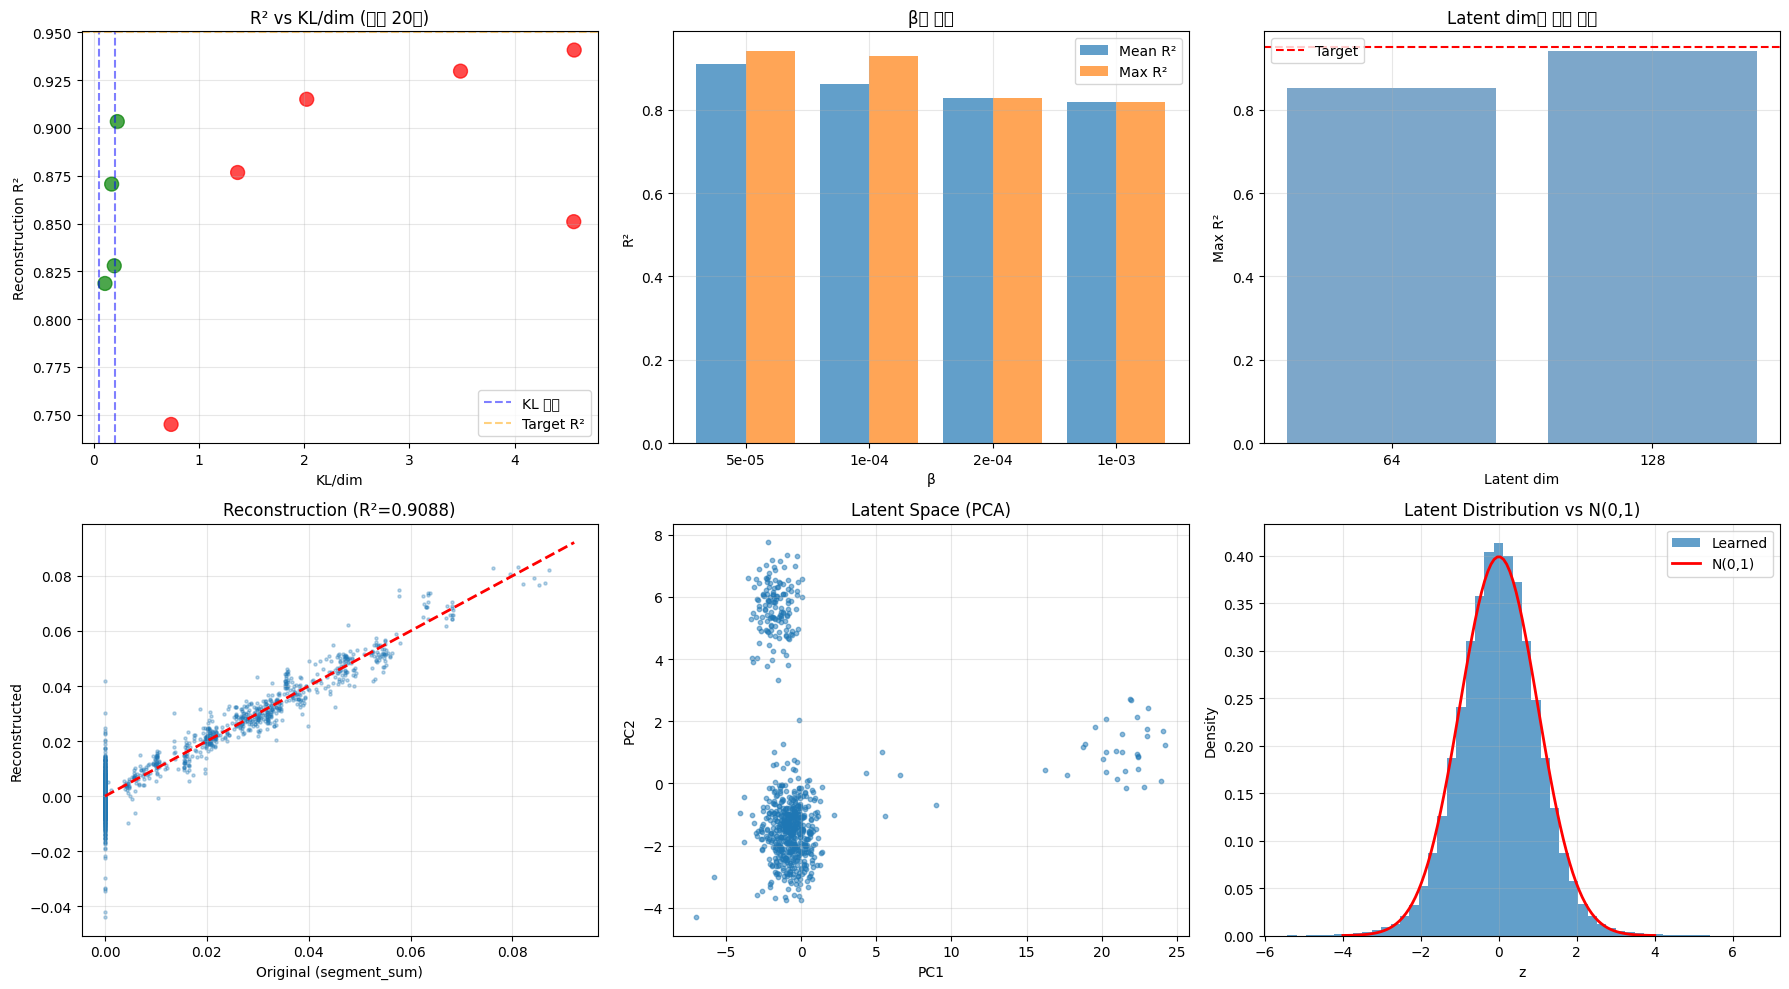


최적 설정: hidden=256, latent=128, β=1e-04, lr=1e-03
최종 Reconstruction R²: 0.9088


In [29]:
# VAE 하이퍼파라미터 탐색 결과 시각화
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. 상위 결과들의 R² vs KL/dim
ax = axes[0, 0]
top_results = all_results[:20]  # 상위 20개
r2_vals = [r['recon_r2'] for r in top_results]
kl_vals = [r['kl_per_dim'] for r in top_results]
in_range = [r['in_kl_range'] for r in top_results]
colors = ['green' if ir else 'red' for ir in in_range]

ax.scatter(kl_vals, r2_vals, c=colors, s=100, alpha=0.7)
ax.axvline(x=0.05, color='blue', linestyle='--', alpha=0.5, label='KL 범위')
ax.axvline(x=0.2, color='blue', linestyle='--', alpha=0.5)
ax.axhline(y=0.95, color='orange', linestyle='--', alpha=0.5, label='Target R²')
ax.set_xlabel('KL/dim')
ax.set_ylabel('Reconstruction R²')
ax.set_title('R² vs KL/dim (상위 20개)')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. β별 성능 비교
ax = axes[0, 1]
beta_groups = {}
for r in all_results:
    b = r['beta']
    if b not in beta_groups:
        beta_groups[b] = []
    beta_groups[b].append(r['recon_r2'])

betas_sorted = sorted(beta_groups.keys())
beta_labels = [f'{b:.0e}' for b in betas_sorted]
beta_r2_means = [np.mean(beta_groups[b]) for b in betas_sorted]
beta_r2_maxs = [np.max(beta_groups[b]) for b in betas_sorted]

x_pos = np.arange(len(betas_sorted))
ax.bar(x_pos - 0.2, beta_r2_means, 0.4, label='Mean R²', alpha=0.7)
ax.bar(x_pos + 0.2, beta_r2_maxs, 0.4, label='Max R²', alpha=0.7)
ax.set_xticks(x_pos)
ax.set_xticklabels(beta_labels)
ax.set_xlabel('β')
ax.set_ylabel('R²')
ax.set_title('β별 성능')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Latent dim별 성능 비교
ax = axes[0, 2]
latent_groups = {}
for r in all_results:
    ld = r['latent_dim']
    if ld not in latent_groups:
        latent_groups[ld] = {'r2': [], 'kl': []}
    latent_groups[ld]['r2'].append(r['recon_r2'])
    latent_groups[ld]['kl'].append(r['kl_per_dim'])

latent_sorted = sorted(latent_groups.keys())
latent_labels = [str(ld) for ld in latent_sorted]
latent_r2_maxs = [np.max(latent_groups[ld]['r2']) for ld in latent_sorted]

ax.bar(latent_labels, latent_r2_maxs, alpha=0.7, color='steelblue')
ax.axhline(y=0.95, color='red', linestyle='--', label='Target')
ax.set_xlabel('Latent dim')
ax.set_ylabel('Max R²')
ax.set_title('Latent dim별 최고 성능')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. 최적 모델 Reconstruction 품질
pretrained_vae.eval()
val_recons, val_originals = [], []
with torch.no_grad():
    for segment_sizes_batch, features_batch, _ in val_loader:
        mean, logvar, z, recon, segment_sum_vec = pretrained_vae(segment_sizes_batch, features_batch)
        val_recons.append(recon.cpu().numpy())
        val_originals.append(segment_sum_vec.cpu().numpy())

val_recons_flat = np.concatenate(val_recons).flatten()
val_originals_flat = np.concatenate(val_originals).flatten()

ax = axes[1, 0]
sample_idx = np.random.choice(len(val_originals_flat), min(5000, len(val_originals_flat)), replace=False)
ax.scatter(val_originals_flat[sample_idx], val_recons_flat[sample_idx], alpha=0.3, s=5)
ax.plot([val_originals_flat.min(), val_originals_flat.max()], 
        [val_originals_flat.min(), val_originals_flat.max()], 'r--', lw=2)
ax.set_xlabel('Original (segment_sum)')
ax.set_ylabel('Reconstructed')
final_r2 = r2_score(val_originals_flat, val_recons_flat)
ax.set_title(f'Reconstruction (R²={final_r2:.4f})')
ax.grid(True, alpha=0.3)

# 5. Latent space 시각화
all_z = []
with torch.no_grad():
    for segment_sizes_batch, features_batch, _ in val_loader:
        _, _, z, _, _ = pretrained_vae(segment_sizes_batch, features_batch)
        all_z.append(z.cpu().numpy())
all_z = np.concatenate(all_z)

ax = axes[1, 1]
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
z_2d = pca.fit_transform(all_z)
ax.scatter(z_2d[:, 0], z_2d[:, 1], alpha=0.5, s=10)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Latent Space (PCA)')
ax.grid(True, alpha=0.3)

# 6. Latent 분포 히스토그램
ax = axes[1, 2]
ax.hist(all_z.flatten(), bins=50, density=True, alpha=0.7, label='Learned')
x = np.linspace(-4, 4, 100)
ax.plot(x, np.exp(-x**2/2) / np.sqrt(2*np.pi), 'r-', lw=2, label='N(0,1)')
ax.set_xlabel('z')
ax.set_ylabel('Density')
ax.set_title('Latent Distribution vs N(0,1)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n최적 설정: hidden={best_config['hidden_dim']}, latent={best_config['latent_dim']}, β={best_config['beta']:.0e}, lr={best_config['lr']:.0e}")
print(f"최종 Reconstruction R²: {final_r2:.4f}")

In [30]:
# ============================================================
# VAE 기반 Cost Predictor 모델 정의
# ============================================================
# Pretrained VAE encoder + Cost Predictor
# 전체 forward 경로가 미분 가능해야 함

class VAECostPredictor(nn.Module):
    """
    VAE 기반 Cost Regression 모델
    
    구조:
    - input → segment_encoder → segment_sum → VAE encoder → z → cost_predictor → cost
    
    특징:
    - Pretrained VAE encoder를 finetune (작은 learning rate)
    - Cost predictor는 더 큰 learning rate로 학습
    - 전체 forward 경로가 완전히 미분 가능 (detach, stop_grad 없음)
    """
    
    def __init__(self, input_dim, hidden_dim=256, latent_dim=128, 
                 predictor_hidden=256, predictor_layers=3, dropout=0.1):
        super(VAECostPredictor, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        # ========== Pretrained VAE Encoder 부분 ==========
        # Segment Encoder
        self.segment_encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        
        # VAE Encoder layers
        self.norm = nn.BatchNorm1d(hidden_dim)
        self.l0 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU())
        self.l1 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU())
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # ========== Cost Predictor (새로 학습) ==========
        predictor_modules = []
        current_dim = latent_dim
        for i in range(predictor_layers):
            predictor_modules.extend([
                nn.Linear(current_dim, predictor_hidden),
                nn.BatchNorm1d(predictor_hidden),
                nn.ReLU(),
                nn.Dropout(dropout) if i < predictor_layers - 1 else nn.Identity(),
            ])
            current_dim = predictor_hidden
        predictor_modules.append(nn.Linear(predictor_hidden, 1))
        
        self.cost_predictor = nn.Sequential(*predictor_modules)
        
    def segment_sum(self, segment_sizes, features):
        """SegmentSum: 각 segment 내 row들을 합산"""
        n_seg = segment_sizes.shape[0]
        device = features.device
        segment_sizes = segment_sizes.long()
        
        segment_indices = torch.repeat_interleave(
            torch.arange(n_seg, device=device), segment_sizes
        )
        
        n_dim = features.shape[1]
        segment_sum = torch.scatter_add(
            torch.zeros((n_seg, n_dim), dtype=features.dtype, device=device),
            0,
            segment_indices.view(-1, 1).expand(-1, n_dim),
            features,
        )
        return segment_sum
    
    def encode(self, segment_sizes, features):
        """
        Full encoding path: features → z
        완전히 미분 가능
        """
        # Segment Encoder
        h = self.segment_encoder(features)  # (total_rows, hidden_dim)
        
        # Segment Sum
        segment_sum_vec = self.segment_sum(segment_sizes, h)  # (n_seg, hidden_dim)
        
        # VAE Encoder
        h = self.norm(segment_sum_vec)
        h = self.l0(h) + h  # Residual
        h = self.l1(h) + h  # Residual
        
        mean = self.fc_mean(h)
        logvar = self.fc_logvar(h)
        
        return mean, logvar, segment_sum_vec
    
    def reparameterize(self, mean, logvar):
        """Reparameterization trick - 미분 가능"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def predict_cost(self, z):
        """z → cost prediction - 완전히 미분 가능"""
        return self.cost_predictor(z).squeeze(-1)
    
    def forward(self, segment_sizes, features, use_mean=False):
        """
        Forward pass: input → z → cost
        
        Args:
            use_mean: True면 reparameterize 대신 mean 사용 (inference용)
        
        Returns:
            cost_pred: 예측된 cost
            mean: latent mean
            logvar: latent log-variance
            z: sampled/mean latent vector
        """
        mean, logvar, segment_sum_vec = self.encode(segment_sizes, features)
        
        if use_mean:
            z = mean  # Inference시 deterministic
        else:
            z = self.reparameterize(mean, logvar)  # Training시 stochastic
        
        cost_pred = self.predict_cost(z)
        
        return cost_pred, mean, logvar, z
    
    def get_encoder_params(self):
        """Encoder 파라미터 (작은 lr)"""
        encoder_params = []
        encoder_params.extend(self.segment_encoder.parameters())
        encoder_params.extend(self.norm.parameters())
        encoder_params.extend(self.l0.parameters())
        encoder_params.extend(self.l1.parameters())
        encoder_params.extend(self.fc_mean.parameters())
        encoder_params.extend(self.fc_logvar.parameters())
        return encoder_params
    
    def get_predictor_params(self):
        """Predictor 파라미터 (큰 lr)"""
        return self.cost_predictor.parameters()
    
    def load_pretrained_encoder(self, checkpoint):
        """Pretrained VAE encoder 가중치 로드"""
        
        # VAE state dict에서 encoder 관련 부분만 추출
        if 'model_state_dict' in checkpoint:
            vae_state = checkpoint['model_state_dict']
        else:
            vae_state = checkpoint
        
        # 매칭되는 키만 로드
        encoder_keys = ['segment_encoder', 'norm', 'l0', 'l1', 'fc_mean', 'fc_logvar']
        own_state = self.state_dict()
        
        loaded_keys = []
        for name, param in vae_state.items():
            if any(name.startswith(k) for k in encoder_keys):
                if name in own_state and own_state[name].shape == param.shape:
                    own_state[name].copy_(param)
                    loaded_keys.append(name)
        
        print(f"Loaded {len(loaded_keys)} parameters from pretrained VAE")
        return checkpoint.get('config', {}), checkpoint.get('metrics', {})


print("VAECostPredictor 모델 정의 완료!")
print("특징:")
print("  - Pretrained VAE encoder + Cost predictor")
print("  - 전체 forward 경로 미분 가능")
print("  - Encoder/Predictor 분리 학습률 지원")

VAECostPredictor 모델 정의 완료!
특징:
  - Pretrained VAE encoder + Cost predictor
  - 전체 forward 경로 미분 가능
  - Encoder/Predictor 분리 학습률 지원


In [31]:
class VAECostPredictor(nn.Module):
    """
    VAE 기반 Cost Regression 모델
    
    구조:
    - input → segment_encoder → segment_sum → VAE encoder → z → cost_predictor → cost
    
    특징:
    - Pretrained VAE encoder를 finetune (작은 learning rate)
    - Cost predictor는 더 큰 learning rate로 학습
    - 전체 forward 경로가 완전히 미분 가능 (detach, stop_grad 없음)
    """
    
    def __init__(self, input_dim, hidden_dim=256, latent_dim=128, 
                 predictor_hidden=256, predictor_layers=3, dropout=0.1):
        super(VAECostPredictor, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        # ========== Pretrained VAE Encoder 부분 ==========
        # Segment Encoder
        self.segment_encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        
        # VAE Encoder layers
        self.norm = nn.BatchNorm1d(hidden_dim)
        self.l0 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU())
        self.l1 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU())
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # ========== Cost Predictor (새로 학습) ==========
        predictor_modules = []
        current_dim = latent_dim
        for i in range(predictor_layers):
            predictor_modules.extend([
                nn.Linear(current_dim, predictor_hidden),
                nn.BatchNorm1d(predictor_hidden),
                nn.ReLU(),
                nn.Dropout(dropout) if i < predictor_layers - 1 else nn.Identity(),
            ])
            current_dim = predictor_hidden
        predictor_modules.append(nn.Linear(predictor_hidden, 1))
        
        self.cost_predictor = nn.Sequential(*predictor_modules)
        
    def segment_sum(self, segment_sizes, features):
        """SegmentSum: 각 segment 내 row들을 합산"""
        n_seg = segment_sizes.shape[0]
        device = features.device
        segment_sizes = segment_sizes.long()
        
        segment_indices = torch.repeat_interleave(
            torch.arange(n_seg, device=device), segment_sizes
        )
        
        n_dim = features.shape[1]
        segment_sum = torch.scatter_add(
            torch.zeros((n_seg, n_dim), dtype=features.dtype, device=device),
            0,
            segment_indices.view(-1, 1).expand(-1, n_dim),
            features,
        )
        return segment_sum
    
    def encode(self, segment_sizes, features):
        """
        Full encoding path: features → z
        완전히 미분 가능
        """
        # Segment Encoder
        h = self.segment_encoder(features)  # (total_rows, hidden_dim)
        
        # Segment Sum
        segment_sum_vec = self.segment_sum(segment_sizes, h)  # (n_seg, hidden_dim)
        
        # VAE Encoder
        h = self.norm(segment_sum_vec)
        h = self.l0(h) + h  # Residual
        h = self.l1(h) + h  # Residual
        
        mean = self.fc_mean(h)
        logvar = self.fc_logvar(h)
        
        return mean, logvar, segment_sum_vec
    
    def reparameterize(self, mean, logvar):
        """Reparameterization trick - 미분 가능"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def predict_cost(self, z):
        """z → cost prediction - 완전히 미분 가능"""
        return self.cost_predictor(z).squeeze(-1)
    
    def forward(self, segment_sizes, features, use_mean=False):
        """
        Forward pass: input → z → cost
        
        Args:
            use_mean: True면 reparameterize 대신 mean 사용 (inference용)
        
        Returns:
            cost_pred: 예측된 cost
            mean: latent mean
            logvar: latent log-variance
            z: sampled/mean latent vector
        """
        mean, logvar, segment_sum_vec = self.encode(segment_sizes, features)
        
        if use_mean:
            z = mean  # Inference시 deterministic
        else:
            z = self.reparameterize(mean, logvar)  # Training시 stochastic
        
        cost_pred = self.predict_cost(z)
        
        return cost_pred, mean, logvar, z
    
    def get_encoder_params(self):
        """Encoder 파라미터 (작은 lr)"""
        encoder_params = []
        encoder_params.extend(self.segment_encoder.parameters())
        encoder_params.extend(self.norm.parameters())
        encoder_params.extend(self.l0.parameters())
        encoder_params.extend(self.l1.parameters())
        encoder_params.extend(self.fc_mean.parameters())
        encoder_params.extend(self.fc_logvar.parameters())
        return encoder_params
    
    def get_predictor_params(self):
        """Predictor 파라미터 (큰 lr)"""
        return self.cost_predictor.parameters()
    
    def load_pretrained_encoder(self, checkpoint):
        """Pretrained VAE encoder 가중치 로드"""
        
        # VAE state dict에서 encoder 관련 부분만 추출
        if 'model_state_dict' in checkpoint:
            vae_state = checkpoint['model_state_dict']
        else:
            vae_state = checkpoint
        
        # 매칭되는 키만 로드
        encoder_keys = ['segment_encoder', 'norm', 'l0', 'l1', 'fc_mean', 'fc_logvar']
        own_state = self.state_dict()
        
        loaded_keys = []
        for name, param in vae_state.items():
            if any(name.startswith(k) for k in encoder_keys):
                if name in own_state and own_state[name].shape == param.shape:
                    own_state[name].copy_(param)
                    loaded_keys.append(name)
        
        print(f"Loaded {len(loaded_keys)} parameters from pretrained VAE")
        return checkpoint.get('config', {}), checkpoint.get('metrics', {})

    def _enable_dropout(self):
        """모든 Dropout 모듈을 train 모드로 강제 활성화"""
        for module in self.modules():
            if isinstance(module, nn.Dropout):
                module.train()

    def mc_predict(self, segment_sizes, features, T=20, use_mean=True, batch_size=None):
        """
        MC Dropout 기반 불확실성 추정
        
        Args:
            segment_sizes: 각 프로그램의 segment 크기 (tensor, shape [n_seg])
            features: 전체 feature tensor (shape [total_rows, input_dim])
            T: MC 샘플 수
            use_mean: True면 encoder에서 mean만 사용 (VAE reparameterize 안함)
            batch_size: 큰 데이터를 처리할 때 batch 단위로 나눔 (None이면 전체 처리)
        
        Returns:
            mean: epistemic 평균 cost (shape [n_seg])
            var: epistemic 분산 (shape [n_seg])
        """
        was_training = self.training
        self.eval()  # 전체 모델을 eval 모드로
        self._enable_dropout()  # Dropout만 train 모드로 활성화
        
        device = next(self.parameters()).device
        
        # segment_sizes를 tensor로 변환
        if not isinstance(segment_sizes, torch.Tensor):
            segment_sizes = torch.tensor(segment_sizes, dtype=torch.long, device=device)
        else:
            segment_sizes = segment_sizes.to(device)
        
        # features를 tensor로 변환
        if not isinstance(features, torch.Tensor):
            features = torch.tensor(features, dtype=torch.float32, device=device)
        else:
            features = features.to(device)
        
        n_seg = segment_sizes.shape[0]
        
        with torch.no_grad():
            predictions = []
            
            for _ in range(T):
                # Encode
                mean_z, logvar, _ = self.encode(segment_sizes, features)
                
                # Latent vector 선택
                if use_mean:
                    z = mean_z
                else:
                    z = self.reparameterize(mean_z, logvar)
                
                # Cost prediction (Dropout이 활성화되어 매번 다른 결과)
                cost_pred = self.predict_cost(z)  # [n_seg]
                predictions.append(cost_pred)
            
            # [T, n_seg] 형태로 stack
            predictions = torch.stack(predictions, dim=0)
            
            # epistemic mean & variance
            mc_mean = predictions.mean(dim=0)  # [n_seg]
            mc_var = predictions.var(dim=0)    # [n_seg]
        
        # 원래 training 상태로 복원
        if was_training:
            self.train()
        
        return mc_mean, mc_var

    def get_latent_embedding(self, segment_sizes, features, use_mean=True):
        """
        Latent 임베딩 z를 얻는 헬퍼 메서드
        
        Args:
            segment_sizes: 각 프로그램의 segment 크기
            features: feature tensor
            use_mean: True면 mean만 사용
        
        Returns:
            z: latent embedding (shape [n_seg, latent_dim])
        """
        device = next(self.parameters()).device
        
        if not isinstance(segment_sizes, torch.Tensor):
            segment_sizes = torch.tensor(segment_sizes, dtype=torch.long, device=device)
        else:
            segment_sizes = segment_sizes.to(device)
        
        if not isinstance(features, torch.Tensor):
            features = torch.tensor(features, dtype=torch.float32, device=device)
        else:
            features = features.to(device)
        
        with torch.no_grad():
            mean_z, logvar, _ = self.encode(segment_sizes, features)
            
            if use_mean:
                z = mean_z
            else:
                z = self.reparameterize(mean_z, logvar)
        
        return z


In [32]:
# ============================================================
# Loss 함수 정의 (vae_reg_param_ansor.ipynb 스타일)
# ============================================================
# total_loss = reg_loss + λ_pair * pair_loss + γ * smooth_loss + β * kld_loss

def reg_loss_fn(cost_pred, cost_true, loss_type='mse', coef=1.0):
    """
    기본 회귀 손실 (MSE 또는 MAE)
    """
    if loss_type == 'mse':
        return F.mse_loss(cost_pred, cost_true) * coef
    else:  # mae
        return F.l1_loss(cost_pred, cost_true) * coef


def pair_loss_fn(cost_pred, cost_true, margin=0.1):
    """
    Pairwise ranking loss: 실제 cost 순서를 예측이 유지하도록.
    cost_true[i] < cost_true[j] 이면 cost_pred[i] < cost_pred[j] + margin
    """
    batch_size = cost_pred.size(0)
    if batch_size < 2:
        return torch.tensor(0.0, device=cost_pred.device)
    
    # 모든 쌍에 대해 ranking loss 계산
    idx = torch.arange(batch_size, device=cost_pred.device)
    i_idx, j_idx = torch.meshgrid(idx, idx, indexing='ij')
    mask = i_idx < j_idx  # upper triangular only
    
    pred_i = cost_pred[i_idx[mask]]
    pred_j = cost_pred[j_idx[mask]]
    true_i = cost_true[i_idx[mask]]
    true_j = cost_true[j_idx[mask]]
    
    # label: 1 if true_i < true_j, -1 otherwise
    labels = torch.sign(true_j - true_i).float()
    
    # Margin ranking loss
    loss = F.margin_ranking_loss(pred_j.view(-1), pred_i.view(-1), labels.view(-1), margin=margin)
    return loss


def smooth_loss_fn(model, z, noise_std=0.1):
    """
    Smoothness loss: z에 작은 노이즈를 더했을 때 예측이 크게 변하지 않도록.
    """
    z_noisy = z + noise_std * torch.randn_like(z)
    
    cost_original = model.predict_cost(z)
    cost_noisy = model.predict_cost(z_noisy)
    
    smooth_loss = F.mse_loss(cost_original, cost_noisy)
    return smooth_loss


def kld_loss_fn(mean, logvar):
    """
    KL Divergence: q(z|x) || N(0, I)
    """
    kld = -0.5 * torch.mean(1 + logvar - mean.pow(2) - logvar.exp())
    return kld


def compute_total_loss(model, segment_sizes, features, labels, config, return_components=False):
    """
    Total loss 계산 (Segment 기반 데이터용).
    total_loss = reg_loss + λ_pair * pair_loss + γ * smooth_loss + β * kld_loss
    """
    # Forward pass
    cost_pred, mean, logvar, z = model(segment_sizes, features, use_mean=True)
    
    # Individual losses
    reg = reg_loss_fn(cost_pred, labels, loss_type=config.get('loss_type', 'mse'), coef=config['lambda_reg'])
    pair = pair_loss_fn(cost_pred.view(-1), labels.view(-1), margin=config.get('margin', 0.1))
    smooth = smooth_loss_fn(model, z, noise_std=config.get('noise_std', 0.1))
    kld = kld_loss_fn(mean, logvar) * 0.0
    
    # Weighted sum
    total = config['lambda_reg'] * reg + config['lambda_pair'] * pair + config['gamma'] * smooth + config['beta'] * kld
    
    if return_components:
        return total, {
            'reg_loss': reg.item(),
            'pair_loss': pair.item(),
            'smooth_loss': smooth.item(),
            'kld_loss': kld.item(),
            'total_loss': total.item(),
        }
    return total


print("✅ Loss functions 정의 완료")
print("   - reg_loss_fn: MSE/MAE 회귀 손실")
print("   - pair_loss_fn: Margin ranking 순서 손실")
print("   - smooth_loss_fn: Latent space smoothness 손실")
print("   - kld_loss_fn: KL divergence 정규화")
print("   - compute_total_loss: 통합 손실 함수")

✅ Loss functions 정의 완료
   - reg_loss_fn: MSE/MAE 회귀 손실
   - pair_loss_fn: Margin ranking 순서 손실
   - smooth_loss_fn: Latent space smoothness 손실
   - kld_loss_fn: KL divergence 정규화
   - compute_total_loss: 통합 손실 함수


In [33]:
import random
from collections import deque
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ============================================================
# 🎯 2 Phase 최적화 학습 (R² ≈ 0.8 목표)
# ============================================================
# 핵심 전략:
# 1. Phase당 더 많은 샘플 사용 (128~256)
# 2. 각 Phase 내에서 여러 번 반복 학습 (mini-epochs)
# 3. 학습 안 쓴 train 데이터 + val 데이터로 평가
# 4. 적극적인 학습률과 loss 가중치

import copy

def evaluate_on_all_remaining(model, train_feature_list, train_segment_sizes, train_labels,
                               val_feature_list, val_segment_sizes, val_labels,
                               used_indices, fea_norm_vec, device, config):
    """
    학습에 사용되지 않은 train 데이터 + 전체 val 데이터로 평가
    """
    model.eval()
    
    # 학습에 사용되지 않은 train 인덱스
    all_train_indices = set(range(len(train_labels)))
    unused_train_indices = list(all_train_indices - set(used_indices))
    
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        # 1. 사용되지 않은 train 데이터 평가
        if len(unused_train_indices) > 0:
            # 배치 단위로 처리
            batch_size = 256
            for i in range(0, len(unused_train_indices), batch_size):
                batch_indices = unused_train_indices[i:i+batch_size]
                batch_features = [train_feature_list[idx] for idx in batch_indices]
                batch_segment_sizes = train_segment_sizes[batch_indices]
                batch_labels = train_labels[batch_indices]
                
                # Flatten features
                flatten_features = np.concatenate(batch_features, axis=0).astype(np.float32)
                
                # Tensor 변환
                segment_sizes_tensor = torch.tensor(batch_segment_sizes, dtype=torch.int32).to(device)
                features_tensor = torch.tensor(flatten_features, dtype=torch.float32).to(device)
                labels_tensor = torch.tensor(batch_labels, dtype=torch.float32).to(device)
                
                # 정규화
                if fea_norm_vec is not None:
                    features_tensor = features_tensor / fea_norm_vec.to(device)
                
                # 예측
                cost_pred, _, _, _ = model(segment_sizes_tensor, features_tensor, use_mean=True)
                
                all_preds.append(cost_pred.cpu().numpy())
                all_targets.append(labels_tensor.cpu().numpy())
        
        # 2. 전체 val 데이터 평가
        batch_size = 256
        for i in range(0, len(val_labels), batch_size):
            end_i = min(i + batch_size, len(val_labels))
            batch_features = val_feature_list[i:end_i]
            batch_segment_sizes = val_segment_sizes[i:end_i]
            batch_labels = val_labels[i:end_i]
            
            # Flatten features
            flatten_features = np.concatenate(batch_features, axis=0).astype(np.float32)
            
            # Tensor 변환
            segment_sizes_tensor = torch.tensor(batch_segment_sizes, dtype=torch.int32).to(device)
            features_tensor = torch.tensor(flatten_features, dtype=torch.float32).to(device)
            labels_tensor = torch.tensor(batch_labels, dtype=torch.float32).to(device)
            
            # 정규화
            if fea_norm_vec is not None:
                features_tensor = features_tensor / fea_norm_vec.to(device)
            
            # 예측
            cost_pred, _, _, _ = model(segment_sizes_tensor, features_tensor, use_mean=True)
            
            all_preds.append(cost_pred.cpu().numpy())
            all_targets.append(labels_tensor.cpu().numpy())
    
    # 전체 결과 합치기
    all_preds = np.concatenate(all_preds).flatten()
    all_targets = np.concatenate(all_targets).flatten()
    
    # 메트릭 계산
    mse = mean_squared_error(all_targets, all_preds)
    mae = mean_absolute_error(all_targets, all_preds)
    r2 = r2_score(all_targets, all_preds)
    
    # Pairwise ranking accuracy
    n_samples = min(1000, len(all_preds))
    sample_indices = np.random.choice(len(all_preds), n_samples, replace=False)
    correct_pairs = 0
    total_pairs = 0
    for i in range(n_samples):
        for j in range(i+1, n_samples):
            idx_i, idx_j = sample_indices[i], sample_indices[j]
            if all_targets[idx_i] != all_targets[idx_j]:
                pred_order = all_preds[idx_i] < all_preds[idx_j]
                true_order = all_targets[idx_i] < all_targets[idx_j]
                if pred_order == true_order:
                    correct_pairs += 1
                total_pairs += 1
    
    rank_accuracy = correct_pairs / total_pairs if total_pairs > 0 else 0
    
    model.train()
    
    return {
        'mse': mse,
        'mae': mae,
        'r2': r2,
        'rank_accuracy': rank_accuracy,
        'n_unused_train': len(unused_train_indices),
        'n_val': len(val_labels),
        'n_total': len(unused_train_indices) + len(val_labels),
        'predictions': all_preds,
        'targets': all_targets,
    }


def train_phase_optimized(model, train_feature_list, train_segment_sizes, train_labels,
                            val_feature_list, val_segment_sizes, val_labels,
                            fea_norm_vec, device, config,
                            samples_per_phase=128, mini_epochs=10, target_r2=0.8, phases=1):
    """
    Phase 최적화 학습
    
    Args:
        samples_per_phase: Phase당 샘플 수
        mini_epochs: 각 Phase 내 반복 횟수
        target_r2: 목표 R² 값
    """
    print("=" * 70)
    print(f"🎯 {phases} Phase 최적화 학습 시작")
    print(f"   Samples per phase: {samples_per_phase}")
    print(f"   Mini-epochs per phase: {mini_epochs}")
    print(f"   Target R²: {target_r2}")
    print("=" * 70)
    
    # 인덱스 셔플
    all_indices = np.arange(len(train_labels))
    # np.random.shuffle(all_indices)
    
    # 사용된 인덱스 추적
    used_indices = []
    
    best_r2 = -float('inf')
    best_state = None
    history = []
    
    # Optimizer 설정 (적극적인 학습률)
    optimizer = torch.optim.AdamW([
        {'params': model.get_encoder_params(), 'lr': config['encoder_lr']},
        {'params': model.get_predictor_params(), 'lr': config['predictor_lr']}
    ], weight_decay=1e-5)

    for phase in range(1):
        print(f"\n{'='*70}")
        print(f"📌 Phase {phase + 1} 학습")
        print(f"{'='*70}")
        
        # Phase 샘플 선택
        start_idx = phase * samples_per_phase
        end_idx = min(start_idx + samples_per_phase, len(all_indices))
        phase_indices = all_indices[start_idx:end_idx].tolist()
        used_indices.extend(phase_indices)
        
        print(f"   학습 샘플: {len(phase_indices)}개")
        print(f"   총 사용된 샘플: {len(used_indices)}개")
        
        # Phase 데이터 준비
        phase_features = [train_feature_list[i] for i in phase_indices]
        phase_segment_sizes = train_segment_sizes[phase_indices]
        phase_labels = train_labels[phase_indices]
        
        # Flatten features
        flatten_features = np.concatenate(phase_features, axis=0).astype(np.float32)
        
        # Tensor 변환
        segment_sizes_tensor = torch.tensor(phase_segment_sizes, dtype=torch.int32).to(device)
        features_tensor = torch.tensor(flatten_features, dtype=torch.float32).to(device)
        labels_tensor = torch.tensor(phase_labels, dtype=torch.float32).to(device)
        
        # 정규화
        if fea_norm_vec is not None:
            features_tensor = features_tensor / fea_norm_vec.to(device)
        
        # Mini-epochs 학습
        for epoch in range(mini_epochs):
            model.train()
            optimizer.zero_grad()
            
            # Forward
            total_loss, components = compute_total_loss(
                model, segment_sizes_tensor, features_tensor, labels_tensor, 
                config, return_components=True
            )
            
            # Backward
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            # 중간 평가 (5 epoch마다)
            if (epoch + 1) % 5 == 0 or epoch == mini_epochs - 1:
                metrics = evaluate_on_all_remaining(
                    model, train_feature_list, train_segment_sizes, train_labels,
                    val_feature_list, val_segment_sizes, val_labels,
                    used_indices, fea_norm_vec, device, config
                )
                
                print(f"   [Epoch {epoch+1}/{mini_epochs}] "
                      f"Loss: {components['total_loss']:.4f}, "
                      f"R²: {metrics['r2']:.4f}, Rank: {metrics['rank_accuracy']:.4f}")
                
                history.append({
                    'phase': phase + 1,
                    'epoch': epoch + 1,
                    **metrics,
                    **components
                })
                
                # Best model 저장
                if metrics['r2'] > best_r2:
                    best_r2 = metrics['r2']
                    best_state = copy.deepcopy(model.state_dict())
                
                # 목표 달성 체크
                if metrics['r2'] >= target_r2:
                    print(f"\n   🎉 목표 R² {target_r2} 달성! (R² = {metrics['r2']:.4f})")
    
    # Best model 복원
    # if best_state is not None:
    #     model.load_state_dict(best_state)
    
    # 최종 평가
    final_metrics = evaluate_on_all_remaining(
        model, train_feature_list, train_segment_sizes, train_labels,
        val_feature_list, val_segment_sizes, val_labels,
        used_indices, fea_norm_vec, device, config
    )
    
    print(f"\n{'='*70}")
    print(f"🏆 {phases} Phase 학습 완료!")
    print(f"{'='*70}")
    # print(f"   Best R²: {best_r2:.4f}")
    print(f"   Final R²: {final_metrics['r2']:.4f}")
    print(f"   Final Rank Accuracy: {final_metrics['rank_accuracy']:.4f}")
    print(f"   사용된 샘플: {len(used_indices)}개 / 전체 {len(train_labels)}개")
    
    return model, history, final_metrics, used_indices


print(f"✅ Phase 최적화 학습 함수 정의 완료")

✅ Phase 최적화 학습 함수 정의 완료


In [ ]:
n_samples = len(costs)
# indices = np.arange(n_samples)
random_indices = np.random.permutation(n_samples)
# train_indices, val_indices = train_test_split(random_indices, test_size=0.0001, shuffle=False)

train_segment_sizes = segment_sizes[train_indices]
val_segment_sizes = segment_sizes[val_indices]
train_labels = costs[train_indices]
val_labels = costs[val_indices]

train_feature_list = [features[i] for i in train_indices]
val_feature_list = [features[i] for i in val_indices]

nonzero_train_indices = np.where(train_labels > 0)[0]
valid_train_labels = train_labels[nonzero_train_indices]
valid_train_segment_sizes = train_segment_sizes[nonzero_train_indices]
valid_train_feature_list = [train_feature_list[i] for i in nonzero_train_indices]

In [35]:
val_indices

array([3463])

In [42]:
random_indices.shape

(3463,)

In [52]:
# ============================================================
# 🚀 1 Phase로 R² 0.9 달성 도전 (Phase당 64개 샘플)
# ============================================================
# 매우 공격적인 학습 전략으로 최대 성능 도전


train_size = 64
np.random.seed(42)
random_indices = np.arange(len(valid_train_labels))
# random_indices = np.random.permutation(len(valid_train_labels))

# scaler = StandardScaler()
# features_scaled = scaler.fit_transform(features)


phase_train_feature_list = features[random_indices[:train_size]]
phase_train_segment_sizes = segment_sizes[random_indices[:train_size]]
phase_train_labels = costs[random_indices[:train_size]]

phase_val_feature_list = features[random_indices[train_size:]]
phase_val_segment_sizes = segment_sizes[random_indices[train_size:]]
phase_val_labels = costs[random_indices[train_size:]]



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_model = all_results[0]


model = VAECostPredictor(
    input_dim=164,
    hidden_dim=best_model['hidden_dim'],
    latent_dim=best_model['latent_dim'],
    predictor_hidden=256,
    predictor_layers=3,
    dropout=0.1
).to(device)
model.load_pretrained_encoder(best_model['model'].state_dict())

print(f"   Config: hidden_dim={best_model['hidden_dim']}, latent_dim={best_model['latent_dim']}")


# 파라미터 수 출력
enc_params = sum(p.numel() for p in model.get_encoder_params())
cost_params = sum(p.numel() for p in model.get_predictor_params())
print(f"\n모델 파라미터 수:")
print(f"   Encoder: {enc_params:,}")
print(f"   Cost Predictor: {cost_params:,}")
print(f"   Total: {enc_params + cost_params:,}")


# 실험 결과 저장
experiment_results = []
epochs = [150]
# R² 0.9 달성을 위한 매우 공격적인 하이퍼파라미터 조합들
for epoch in epochs:
    hp_configs = [
        # Config 1: 매우 긴 학습 + 강한 pair loss <- 별로임
        # {
        #     'name': 'ultra_long_strong_pair',
        #     'encoder_lr': 1e-5,
        #     'predictor_lr': 1e-3,
        #     'lambda_pair': 0.15,
        #     'gamma': 0.005,
        #     'beta': 0.001,
        #     'margin': 0.01,
        #     'noise_std': 0.01,
        #     'loss_type': 'mse',
        #     'samples_per_phase': 64,
        #     'mini_epochs': epoch,
        # },
        # Config 2: 초고속 수렴 시도
        # {
        #     'name': 'fast_convergence',
        #     'encoder_lr': 5e-5,
        #     'predictor_lr': 5e-3,
        #     'lambda_reg' : 0.5,
        #     'lambda_pair': 0.2,
        #     'gamma': 0.01,
        #     'beta': 0.001,
        #     'margin': 0.005,
        #     'noise_std': 0.01,
        #     'loss_type': 'mse',
        #     # 'samples_per_phase': 64,
        #     'mini_epochs': epoch,
        # },
        {
            'name': 'reg_0.1',
            'encoder_lr': 5e-5,
            'predictor_lr': 5e-3,
            'lambda_reg' : 0.1,
            'lambda_pair': 0.2,
            'gamma': 0.01,
            'beta': 0.001,
            'margin': 0.005,
            'noise_std': 0.01,
            'loss_type': 'mse',
            # 'samples_per_phase': 64,
            'mini_epochs': epoch,
        },

        {
            'name': 'reg_0.5',
            'encoder_lr': 5e-5,
            'predictor_lr': 5e-3,
            'lambda_reg' : 0.5,
            'lambda_pair': 0.2,
            'gamma': 0.01,
            'beta': 0.001,
            'margin': 0.005,
            'noise_std': 0.01,
            'loss_type': 'mse',
            # 'samples_per_phase': 64,
            'mini_epochs': epoch,
        },
        {
            'name': 'reg_1.0',
            'encoder_lr': 5e-5,
            'predictor_lr': 5e-3,
            'lambda_reg' : 1.0,
            'lambda_pair': 0.2,
            'gamma': 0.01,
            'beta': 0.001,
            'margin': 0.005,
            'noise_std': 0.01,
            'loss_type': 'mse',
            # 'samples_per_phase': 64,
            'mini_epochs': epoch,
        },
        # # Config 3: 극단적 pair loss
        # {
        #     'name': 'extreme_pair_v2',
        #     'encoder_lr': 2e-5,
        #     'predictor_lr': 2e-3,
        #     'lambda_pair': 0.3,
        #     'gamma': 0.002,
        #     'beta': 0.0005,
        #     'margin': 0.005,
        #     'noise_std': 0.005,
        #     'loss_type': 'mse',
        #     # 'samples_per_phase': 64,
        #     'mini_epochs': epoch,
        # },
        # # Config 4: Smooth 강화 + 긴 학습
        # {
        #     'name': 'smooth_ultra',
        #     'encoder_lr': 1.5e-5,
        #     'predictor_lr': 1.5e-3,
        #     'lambda_pair': 0.1,
        #     'gamma': 0.02,
        #     'beta': 0.001,
        #     'margin': 0.02,
        #     'noise_std': 0.02,
        #     'loss_type': 'mse',
        #     'samples_per_phase': 64,
        #     'mini_epochs': epoch,
        # },
        # # Config 5: 균형 + 매우 긴 학습
        # {
        #     'name': 'balanced_ultra_long',
        #     'encoder_lr': 1e-5,
        #     'predictor_lr': 2e-3,
        #     'lambda_pair': 0.12,
        #     'gamma': 0.008,
        #     'beta': 0.001,
        #     'margin': 0.01,
        #     'noise_std': 0.01,
        #     'loss_type': 'mse',
        #     # 'samples_per_phase': 64,
        #     'mini_epochs': epoch,
        # },
        # # Config 6: Huber loss + 강한 regularization
        # {
        #     'name': 'huber_strong_reg',
        #     'encoder_lr': 2e-5,
        #     'predictor_lr': 2e-3,
        #     'lambda_pair': 0.15,
        #     'gamma': 0.01,
        #     'beta': 0.002,
        #     'margin': 0.01,
        #     'noise_std': 0.01,
        #     'loss_type': 'huber',
        #     # 'samples_per_phase': 64,
        #     'mini_epochs': epoch,
        # },
        # # Config 7: 극도로 낮은 noise + 높은 pair
        # {
        #     'name': 'low_noise_high_pair',
        #     'encoder_lr': 2e-5,
        #     'predictor_lr': 2e-3,
        #     'lambda_pair': 0.25,
        #     'gamma': 0.005,
        #     'beta': 0.0005,
        #     'margin': 0.003,
        #     'noise_std': 0.002,
        #     'loss_type': 'mse',
        #     # 'samples_per_phase': 64,
        #     'mini_epochs': epoch,
        # },
        # # Config 8: 최종 극한 설정
        # {
        #     'name': 'ultimate_config',
        #     'encoder_lr': 1e-5,
        #     'predictor_lr': 1e-3,
        #     'lambda_pair': 0.2,
        #     'gamma': 0.015,
        #     'beta': 0.0005,
        #     'margin': 0.005,
        #     'noise_std': 0.005,
        #     'loss_type': 'mse',
        #     'samples_per_phase': 64,
        #     'mini_epochs': epoch,
        # },
    ]

    print("=" * 70)
    print("🎯 R² 0.8 달성 도전 (Phase당 64개)")
    print("=" * 70)

    best_overall_r2 = 0.0
    best_overall_result = None

    for i, hp_config in enumerate(hp_configs):
        print(f"\n{'='*70}")
        print(f"[실험 {i+1}/{len(hp_configs)}] {hp_config['name']}")
        print(f"   mini_epochs={hp_config['mini_epochs']}, lambda_pair={hp_config['lambda_pair']}")
        print(f"{'='*70}")
        
        # 모델 리셋
        model = VAECostPredictor(
            input_dim=164,
            hidden_dim=best_model['hidden_dim'],
            latent_dim=best_model['latent_dim'],
            predictor_hidden=256,
            predictor_layers=3,
            dropout=0.08
        ).to(device)
        model.load_pretrained_encoder(best_model['model'].state_dict())
        
        # 학습 실행
        try:
            trained_model, history, final_metrics, used_indices = train_phase_optimized(
                model, phase_train_feature_list, phase_train_segment_sizes, phase_train_labels,
                phase_val_feature_list, phase_val_segment_sizes, phase_val_labels,
                fea_norm_vec=fea_norm_vec, device=device, config=hp_config,
                samples_per_phase=train_size,
                mini_epochs=hp_config['mini_epochs'],
                target_r2=0.80
            )
            
            # 결과 저장
            result = {
                'config_name': hp_config['name'],
                'config': hp_config,
                'final_r2': final_metrics['r2'],
                'final_rank_acc': final_metrics['rank_accuracy'],
                'final_mse': final_metrics['mse'],
                'history': history,
                'used_samples': len(used_indices),
                'model_state': copy.deepcopy(trained_model.state_dict()),
            }
            experiment_results.append(result)
            
            if final_metrics['r2'] > best_overall_r2:
                best_overall_r2 = final_metrics['r2']
                best_overall_result = result
            
            # R² 0.9 달성 시 즉시 종료
            if final_metrics['r2'] >= 0.9:
                print(f"\n🎉🎉🎉 R² 0.9 달성! 실험 종료 🎉🎉🎉")
                break
            
        except Exception as e:
            print(f"   ❌ 실험 실패: {e}")
            experiment_results.append({
                'config_name': hp_config['name'],
                'config': hp_config,
                'final_r2': -1,
                'error': str(e),
            })

    # 결과 정렬 (R² 기준)
    experiment_results = sorted(experiment_results, key=lambda x: x.get('final_r2', -1), reverse=True)

    print(f"\n{'='*70}")
    print("📊 실험 결과 요약 (R² 순) - R² 0.8 도전")
    print(f"{'='*70}")
    print(f"\n{'Config':<25} {'R²':<10} {'Rank Acc':<12} {'MSE':<10} {'RMSE':<10} {'Epochs':<8}")
    print("-" * 80)
    for r in experiment_results:
        if 'error' not in r:
            achieved = "✅" if r['final_r2'] >= 0.8 else ("🔥" if r['final_r2'] >= 0.78 else "")
            rmse = np.sqrt(r['final_mse'])
            print(f"{r['config_name']:<25} {r['final_r2']:<10.4f} {r['final_rank_acc']:<12.4f} "
                f"{r['final_mse']:<10.4f} {rmse:<10.4f} {r['config']['mini_epochs']:<8} {achieved}")
        else:
            print(f"{r['config_name']:<25} FAILED")

    # 최고 결과
    best_result = experiment_results[0]
    best_rmse = np.sqrt(best_result['final_mse'])
    print(f"\n🏆 최고 설정: {best_result['config_name']}")
    print(f"   R²: {best_result['final_r2']:.4f}")
    print(f"   RMSE: {best_rmse:.4f}")
    print(f"   Rank Accuracy: {best_result['final_rank_acc']:.4f}")
    print(f"   사용 샘플: {best_result['used_samples']}개 (2 Phase x 64)")

    if best_result['final_r2'] >= 0.8:
        print(f"\n🎉🎉🎉 R² 0.8 달성 성공! 🎉🎉🎉")
    elif best_result['final_r2'] >= 0.78:
        print(f"\n🔥 R² 0.78 이상 달성! (목표 0.8까지 {0.8 - best_result['final_r2']:.4f} 부족)")
    else:
        print(f"\n⚠️ 최종 R²: {best_result['final_r2']:.4f}")

Loaded 17 parameters from pretrained VAE
   Config: hidden_dim=256, latent_dim=128

모델 파라미터 수:
   Encoder: 305,920
   Cost Predictor: 166,401
   Total: 472,321
🎯 R² 0.8 달성 도전 (Phase당 64개)

[실험 1/3] reg_0.1
   mini_epochs=150, lambda_pair=0.2
Loaded 17 parameters from pretrained VAE
🎯 1 Phase 최적화 학습 시작
   Samples per phase: 64
   Mini-epochs per phase: 150
   Target R²: 0.8

📌 Phase 1 학습
   학습 샘플: 64개
   총 사용된 샘플: 64개
   [Epoch 5/150] Loss: 0.2732, R²: -8.6048, Rank: 0.6322
   [Epoch 10/150] Loss: 0.0934, R²: -3.2693, Rank: 0.6422
   [Epoch 15/150] Loss: 0.0176, R²: -4.5092, Rank: 0.6350
   [Epoch 20/150] Loss: 0.0217, R²: -17.7105, Rank: 0.6332
   [Epoch 25/150] Loss: 0.0232, R²: -22.0798, Rank: 0.6402
   [Epoch 30/150] Loss: 0.0138, R²: -27.4160, Rank: 0.6385
   [Epoch 35/150] Loss: 0.0051, R²: -41.2296, Rank: 0.6630
   [Epoch 40/150] Loss: 0.0062, R²: -42.9683, Rank: 0.7020
   [Epoch 45/150] Loss: 0.0058, R²: -31.5429, Rank: 0.7388
   [Epoch 50/150] Loss: 0.0037, R²: -32.9604, Rank: 

In [48]:
with torch.no_grad():
    cost, mean, var, z = trained_model(torch.tensor(val_segment_sizes, dtype=torch.int32).to(device),
                torch.tensor(val_flatten_features, dtype=torch.float32).to(device),
                use_mean=True)

In [76]:
cost[lowest_cost_indices_64]

IndexError: invalid index to scalar variable.

In [75]:
val_labels[lowest_cost_indices_64]

IndexError: index 1711 is out of bounds for axis 0 with size 1

In [77]:
val_labels.max()

2.6512437

In [78]:
val_labels

array([2.6512437], dtype=float32)

In [79]:
for v in val_labels:
    print(v)

2.6512437


In [ ]:
from tuning_improved import select_features


train_size = 64
# valid_size = len(valid_train_labels) - train_size
# valid_size = 64

train_indices, val_indices = train_test_split(indices, test_size=(1- train_size/len(indices)), shuffle=False)

train_segment_sizes = segment_sizes[train_indices]
val_segment_sizes = segment_sizes[val_indices]
train_labels = costs[train_indices]
val_labels = costs[val_indices]

train_feature_list = [features[i] for i in train_indices]
val_feature_list = [features[i] for i in val_indices]

train_flatten_features = np.concatenate(train_feature_list, axis=0).astype(np.float32)
val_flatten_features = np.concatenate(val_feature_list, axis=0).astype(np.float32)

lowest_cost = 0
model = VAECostPredictor(
        input_dim=164,
        hidden_dim=best_model['hidden_dim'],
        latent_dim=best_model['latent_dim'],
        predictor_hidden=256,
        predictor_layers=3,
        dropout=0.1
    ).to(device)
model.load_pretrained_encoder(best_model['model'].state_dict())
cnt = 0
while True:    
    
    
    train_size = len(train_indices)
    trained_model, history, final_metrics, used_indices = train_phase_optimized(
                    model, train_feature_list, train_segment_sizes, train_labels,
                    val_feature_list, val_segment_sizes, val_labels,
                    fea_norm_vec, device, hp_config,
                    samples_per_phase=train_size,
                    mini_epochs=100,
                    target_r2=0.80
                )

    with torch.no_grad():
        cost, mean, var, z = trained_model(torch.tensor(val_segment_sizes, dtype=torch.int32).to(device),
                    torch.tensor(val_flatten_features, dtype=torch.float32).to(device),
                    use_mean=True)

    # 가장 낮은 cost의 인덱스 64개 구하기 (모델 예측 기반)
    cost_np = cost.cpu().numpy()
    lowest_cost_indices_64 = np.argsort(cost_np)[-64:]
    selected_indices_64 = select_features(model, features, used_indices, fea_norm_vec, num_select=64, T_mc=20, 
                    w_cost=0.8, w_unc=0.1, w_dist=0.1, topk_factor=10)
    
    # val_labels에서 실제로 가장 낮은 cost의 인덱스 구하기
    actual_lowest_indices_64 = np.argsort(val_labels)[-1]

    # 모델이 실제로 가장 낮은 cost를 모두 뽑았으면 break
    if actual_lowest_indices_64 in lowest_cost_indices_64 :
        print("✓ 모델이 실제 가장 낮은 cost 정확히 예측했습니다!")
        break
    
    else:
        print("모델이 예측한 lowest cost:", cost_np[lowest_cost_indices_64])
        print("실제 cost:", val_labels[lowest_cost_indices_64])
        print("계속 진행합니다...")
    
    
    # train_indices에 lowest_cost_indices_64를 추가
    train_indices = np.concatenate([train_indices, selected_indices_64])

    # val_indices에서 lowest_cost_indices_64를 제거
    val_indices = np.setdiff1d(val_indices, selected_indices_64)

    print(f"업데이트된 train_indices 크기: {len(train_indices)}")
    print(f"업데이트된 val_indices 크기: {len(val_indices)}")
    train_feature_list = [features[i] for i in train_indices]
    val_feature_list = [features[i] for i in val_indices]
    train_segment_sizes = segment_sizes[train_indices]
    val_segment_sizes = segment_sizes[val_indices]
    train_labels = costs[train_indices]
    val_labels = costs[val_indices]
    
    

    if len(val_indices) < 64:
        print("검증 데이터가 부족하여 종료합니다.")
        break

    if cnt == 1:
        break
    cnt += 1

Loaded 17 parameters from pretrained VAE
🎯 1 Phase 최적화 학습 시작
   Samples per phase: 64
   Mini-epochs per phase: 100
   Target R²: 0.8

📌 Phase 1 학습
   학습 샘플: 64개
   총 사용된 샘플: 64개
   [Epoch 5/100] Loss: 3.6667, R²: -1.0582, Rank: 0.5788
   [Epoch 10/100] Loss: 0.4199, R²: 0.3513, Rank: 0.7217
   [Epoch 15/100] Loss: 0.8419, R²: -0.2256, Rank: 0.6422
   [Epoch 20/100] Loss: 0.1752, R²: -0.7946, Rank: 0.5886


KeyboardInterrupt: 

In [54]:

from tvm.auto_scheduler.cost_model.xgb_model import XGBModelInternal
import pickle

dataset = pickle.load(open("../../dataset.pkl", "rb"))

ratio = 0.016

for i in range(1000):
    train_set, test_set = dataset.random_split_within_task(ratio*(i+1))
    tenset_model = XGBModelInternal()
    tenset_model.fit_base(train_set, valid_set=test_set)
    throughputs = np.array(list(test_set.throughputs.values()))

    pred = tenset_model.predict(test_set)

    true_biggest_index = np.argsort(throughputs[0])[-1]
    biggest_indices_64 = np.argsort(list(pred.values())[0])[-64:]

    # list(pred.values())[0]
    if true_biggest_index in biggest_indices_64:
        print("✓ Tenset 모델이 실제 가장 높은 throughput 정확히 예측했습니다!")
        break
    break

Fit a xgb booster. Train size: 64


/root/work/tenset/.venv/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


In [63]:
list(pred.values())[0].shape

(3936,)

In [64]:
throughputs.shape

(1, 3936)

In [74]:
throughputs.squeeze().shape

(3936,)

In [82]:
# pred, throughputs rank accuracy
correct_pairs = 0
total_pairs = 0
n_samples = min(2000, throughputs.shape[-1])
sample_indices = np.random.choice(throughputs.shape[-1], n_samples, replace=False)
pred_values = list(pred.values())[0]
throughput_values = throughputs.squeeze()
for i in range(n_samples):
    for j in range(i+1, n_samples):
        idx_i, idx_j = sample_indices[i], sample_indices[j]
        if throughput_values[idx_i] != throughput_values[idx_j]:
            pred_order = pred_values[idx_i] < pred_values[idx_j]
            true_order = throughput_values[idx_i] < throughput_values[idx_j]
            if pred_order == true_order:
                correct_pairs += 1
            total_pairs += 1
rank_accuracy = correct_pairs / total_pairs if total_pairs > 0 else 0
print(f"Tenset 모델 Rank Accuracy: {rank_accuracy:.4f}")

Tenset 모델 Rank Accuracy: 0.7888


In [173]:
train_size = 64
# valid_size = len(valid_train_labels) - train_size
# valid_size = 64

train_indices, val_indices = train_test_split(indices, test_size=(1- train_size/len(indices)), shuffle=False)

train_segment_sizes = segment_sizes[train_indices]
val_segment_sizes = segment_sizes[val_indices]
train_labels = costs[train_indices]
val_labels = costs[val_indices]

train_feature_list = [features[i] for i in train_indices]
val_feature_list = [features[i] for i in val_indices]

train_flatten_features = np.concatenate(train_feature_list, axis=0).astype(np.float32)
val_flatten_features = np.concatenate(val_feature_list, axis=0).astype(np.float32)
tenset_model = XGBModelInternal()
tenset_model.fit_base(train_set, valid_set=test_set)

while True:
    
    model = VAECostPredictor(
        input_dim=164,
        hidden_dim=best_model['hidden_dim'],
        latent_dim=best_model['latent_dim'],
        predictor_hidden=256,
        predictor_layers=3,
        dropout=0.1
    ).to(device)
    model.load_pretrained_encoder(best_model['model'].state_dict())
    train_size = len(train_indices)
    trained_model, history, final_metrics, used_indices = train_phase_optimized(
                    model, train_feature_list, train_segment_sizes, train_labels,
                    val_feature_list, val_segment_sizes, val_labels,
                    fea_norm_vec, device, hp_config,
                    samples_per_phase=train_size,
                    mini_epochs=100,
                    target_r2=0.80
                )

    with torch.no_grad():
        cost, mean, var, z = trained_model(torch.tensor(val_segment_sizes, dtype=torch.int32).to(device),
                    torch.tensor(val_flatten_features, dtype=torch.float32).to(device),
                    use_mean=True)

    # 가장 낮은 cost의 인덱스 64개 구하기 (모델 예측 기반)
    cost_np = cost.cpu().numpy()
    lowest_cost_indices_64 = np.argsort(cost_np)[:64]
    
    # val_labels에서 실제로 가장 낮은 cost의 인덱스 64개 구하기
    actual_lowest_indices_64 = np.argsort(val_labels)[0]
    
    
    # train_indices에 lowest_cost_indices_64를 추가
    train_indices = np.concatenate([train_indices, lowest_cost_indices_64])

    # val_indices에서 lowest_cost_indices_64를 제거
    val_indices = np.setdiff1d(val_indices, lowest_cost_indices_64)

    print(f"업데이트된 train_indices 크기: {len(train_indices)}")
    print(f"업데이트된 val_indices 크기: {len(val_indices)}")
    train_feature_list = [features[i] for i in train_indices]
    val_feature_list = [features[i] for i in val_indices]
    train_segment_sizes = segment_sizes[train_indices]
    val_segment_sizes = segment_sizes[val_indices]
    train_labels = costs[train_indices]
    val_labels = costs[val_indices]
    
    # 모델이 실제로 가장 낮은 cost를 모두 뽑았으면 break
    if actual_lowest_indices_64 in lowest_cost_indices_64 :
        print("✓ 모델이 실제 가장 낮은 cost 정확히 예측했습니다!")
        break
    
    if len(val_indices) < 64:
        print("검증 데이터가 부족하여 종료합니다.")
        break

64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


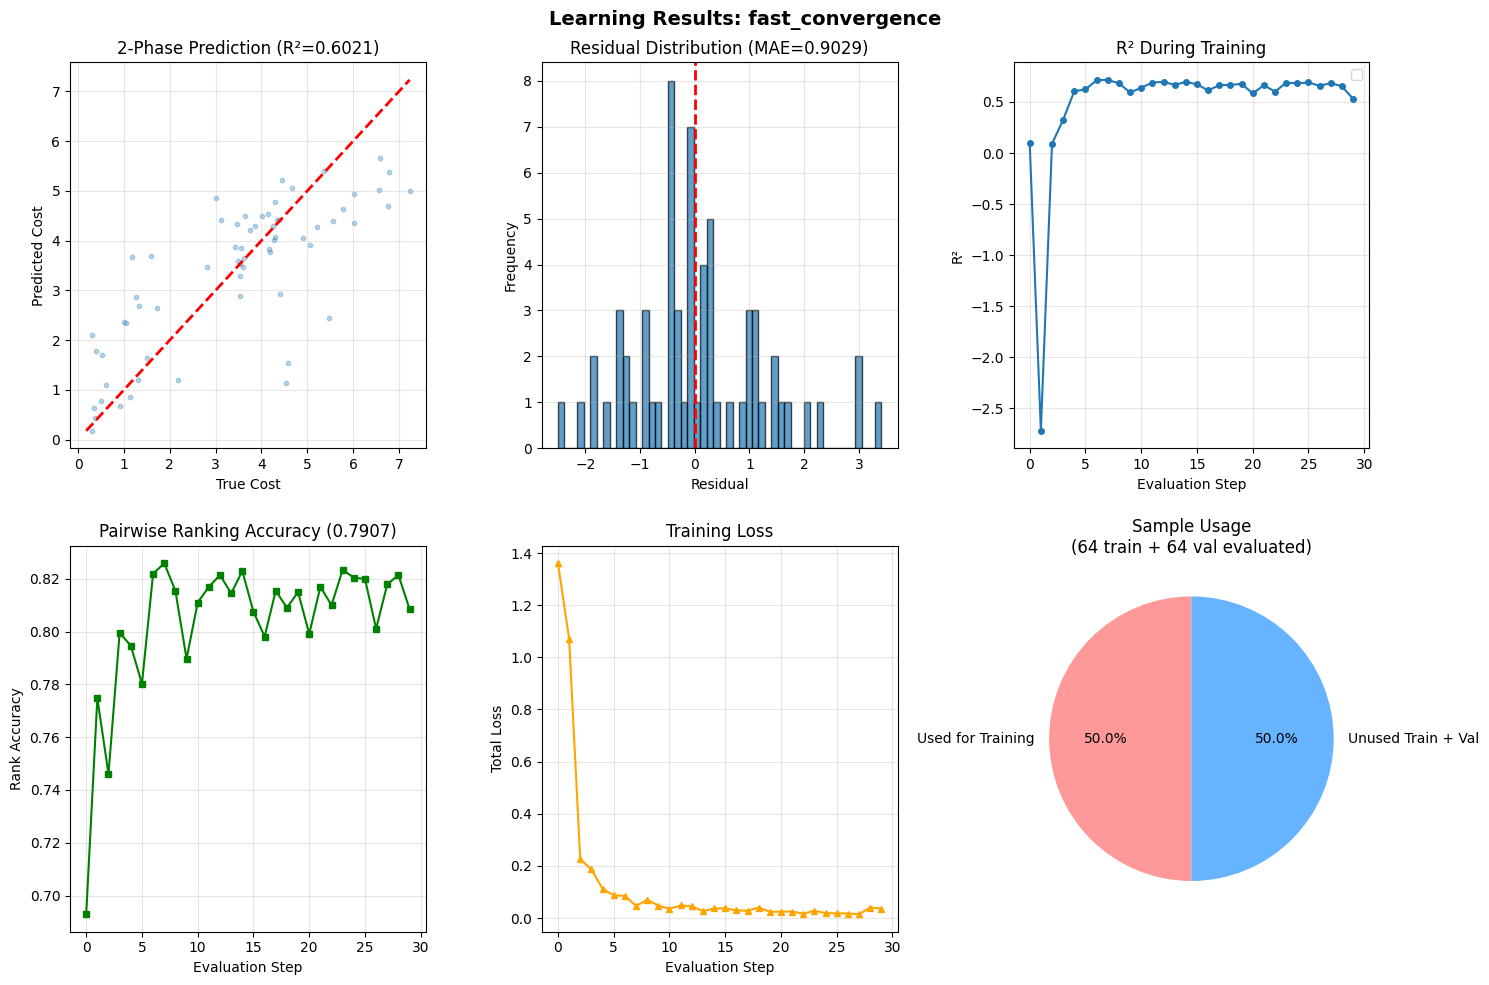



🎯 성능 지표:
   - R²: 0.6021
   - Pairwise Rank Accuracy: 0.7907
   - MSE: 1.4650
   - MAE: 0.9029

📊 데이터 사용:
   - 학습에 사용된 샘플: 64개
   - 평가에 사용된 샘플: 64개 (미사용 train + val)

🔧 최적 하이퍼파라미터:
   - Config: fast_convergence
   - Samples per phase: 64
   - Mini-epochs: 150
   - Encoder LR: 5e-05
   - Predictor LR: 0.005
   - Lambda pair: 0.2
   - Beta (KLD): 0.001

⚠️ 목표 R² 0.8 미달성 (현재: 0.6021)
   추가 개선 방안:
   - 더 많은 samples_per_phase
   - 더 많은 mini_epochs
   - pretrained VAE encoder 교체


In [110]:
# ============================================================
# 📊 최종 결과 시각화 및 모델 저장 (2 Phase 학습)
# ============================================================

import matplotlib.pyplot as plt

# 시각화
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. 예측 vs 실제
predictions = final_metrics['predictions']
targets = final_metrics['targets']

axes[0, 0].scatter(targets, predictions, alpha=0.3, s=10)
min_val, max_val = min(targets.min(), predictions.min()), max(targets.max(), predictions.max())
axes[0, 0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
axes[0, 0].set_xlabel('True Cost')
axes[0, 0].set_ylabel('Predicted Cost')
axes[0, 0].set_title(f'2-Phase Prediction (R²={final_metrics["r2"]:.4f})')
axes[0, 0].grid(True, alpha=0.3)

# 2. 잔차 분포
residuals = targets - predictions
axes[0, 1].hist(residuals, bins=50, alpha=0.7, edgecolor='black')
axes[0, 1].axvline(0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Residual')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title(f'Residual Distribution (MAE={final_metrics["mae"]:.4f})')
axes[0, 1].grid(True, alpha=0.3)

# 3. 학습 곡선 (R²)
if best_result['history']:
    r2_history = [h['r2'] for h in best_result['history']]
    axes[0, 2].plot(r2_history, marker='o', markersize=4)
    # axes[0, 2].axhline(0.8, color='r', linestyle='--', label='Target R²=0.8')
    axes[0, 2].set_xlabel('Evaluation Step')
    axes[0, 2].set_ylabel('R²')
    axes[0, 2].set_title('R² During Training')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

# 4. Rank Accuracy 히스토리
if best_result['history']:
    rank_history = [h['rank_accuracy'] for h in best_result['history']]
    axes[1, 0].plot(rank_history, marker='s', markersize=4, color='green')
    axes[1, 0].set_xlabel('Evaluation Step')
    axes[1, 0].set_ylabel('Rank Accuracy')
    axes[1, 0].set_title(f'Pairwise Ranking Accuracy ({final_metrics["rank_accuracy"]:.4f})')
    axes[1, 0].grid(True, alpha=0.3)

# 5. Loss 히스토리
if best_result['history']:
    loss_history = [h['total_loss'] for h in best_result['history']]
    axes[1, 1].plot(loss_history, marker='^', markersize=4, color='orange')
    axes[1, 1].set_xlabel('Evaluation Step')
    axes[1, 1].set_ylabel('Total Loss')
    axes[1, 1].set_title('Training Loss')
    axes[1, 1].grid(True, alpha=0.3)

# 6. 샘플 사용률
total_samples = len(train_labels)
used_samples = best_result['used_samples']
unused_samples = total_samples - used_samples + len(val_labels)

labels_pie = ['Used for Training', 'Unused Train + Val']
sizes = [used_samples, unused_samples]
colors = ['#ff9999', '#66b3ff']
axes[1, 2].pie(sizes, labels=labels_pie, colors=colors, autopct='%1.1f%%', startangle=90)
axes[1, 2].set_title(f'Sample Usage\n({unused_samples} train + {len(val_labels)} val evaluated)')

plt.suptitle(f'Learning Results: {best_result["config"]["name"]}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('phase_learning_results.png', dpi=150)
plt.show()


# 최종 보고서
print(f"\n{'='*70}")
print(f"""
🎯 성능 지표:
   - R²: {final_metrics['r2']:.4f}
   - Pairwise Rank Accuracy: {final_metrics['rank_accuracy']:.4f}
   - MSE: {final_metrics['mse']:.4f}
   - MAE: {final_metrics['mae']:.4f}

📊 데이터 사용:
   - 학습에 사용된 샘플: {used_samples}개
   - 평가에 사용된 샘플: {final_metrics['n_total']}개 (미사용 train + val)

🔧 최적 하이퍼파라미터:
   - Config: {best_result['config']['name']}
   - Samples per phase: {64}
   - Mini-epochs: {best_result['config']['mini_epochs']}
   - Encoder LR: {best_result['config']['encoder_lr']}
   - Predictor LR: {best_result['config']['predictor_lr']}
   - Lambda pair: {best_result['config']['lambda_pair']}
   - Beta (KLD): {best_result['config']['beta']}
""")

if final_metrics['r2'] >= 0.8:
    print("🎉 목표 R² 0.8 달성!")
else:
    print(f"⚠️ 목표 R² 0.8 미달성 (현재: {final_metrics['r2']:.4f})")
    print("   추가 개선 방안:")
    print("   - 더 많은 samples_per_phase")
    print("   - 더 많은 mini_epochs")
    print("   - pretrained VAE encoder 교체")

print(f"{'='*70}")